In [22]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# load the CIFAR10 data
(x_train, _), (x_test, _) = cifar10.load_data()

# input image dimensions
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

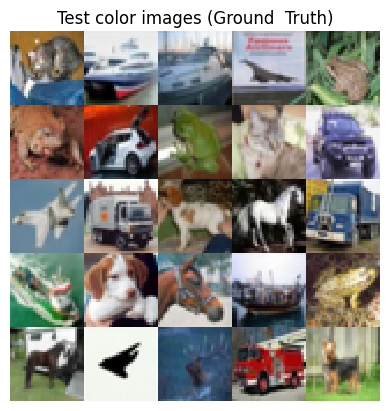

In [12]:
# display the 1st 100 input images (color and gray)
imgs = x_test[:25]
imgs = imgs.reshape((5, 5, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.show()

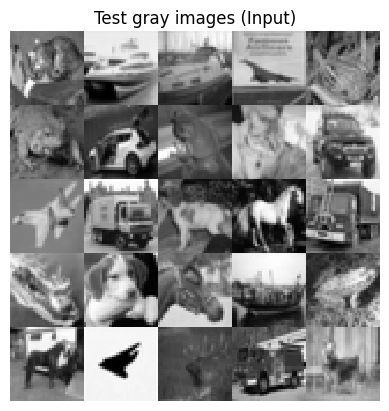

In [13]:
# convert color train and test images to gray
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

# display grayscale version of test images
imgs = x_test_gray[:25]
imgs = imgs.reshape((5, 5, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()

In [14]:
# normalize output train and test color images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# normalize input train and test grayscale images
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

# reshape images to row x col x channel for CNN output/validation
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

# reshape images to row x col x channel for CNN input
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

In [15]:
# network parameters
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [64, 128]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (4, 4, 256) which is processed by the decoder back to (32, 32, 3)
shape = K.int_shape(x)

# generate a latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        640       
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 latent_vector (Dense)       (None, 256)               2097408   
                                                                 
Total params: 2,171,904
Trainable params: 2,171,904
Non-trainable params: 0
_________________________________________________________________


In [19]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)


# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense_2 (Dense)             (None, 8192)              2105344   
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 16, 16, 128)      147584    
 ranspose)                                                       
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 32, 32, 64)       73792     
 ranspose)                                                       
                                                                 
 decoder_output (Conv2DTrans  (None, 32, 32, 3)        1731

In [20]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()


# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 encoder (Functional)        (None, 256)               2171904   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         2328451   
                                                                 
Total params: 4,500,355
Trainable params: 4,500,355
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

# called every epoch
callbacks = [lr_reducer, checkpoint]

# train the autoencoder
autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=30,
                batch_size=batch_size,
                callbacks=callbacks)

# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test_gray)

Epoch 1/30
1556/1563 [============================>.] - ETA: 0s - loss: 0.0110
Epoch 1: val_loss improved from inf to 0.00945, saving model to /content/saved_models/colorized_ae_model.001.h5
1563/1563 [==============================] - 16s 9ms/step - loss: 0.0110 - val_loss: 0.0094 - lr: 0.0010
Epoch 2/30
1561/1563 [============================>.] - ETA: 0s - loss: 0.0084
Epoch 2: val_loss improved from 0.00945 to 0.00816, saving model to /content/saved_models/colorized_ae_model.002.h5
1563/1563 [==============================] - 14s 9ms/step - loss: 0.0084 - val_loss: 0.0082 - lr: 0.0010
Epoch 3/30
1557/1563 [============================>.] - ETA: 0s - loss: 0.0078
Epoch 3: val_loss improved from 0.00816 to 0.00761, saving model to /content/saved_models/colorized_ae_model.003.h5
1563/1563 [==============================] - 13s 8ms/step - loss: 0.0078 - val_loss: 0.0076 - lr: 0.0010
Epoch 4/30
1563/1563 [==============================] - ETA: 0s - loss: 0.0074
Epoch 4: val_loss improve

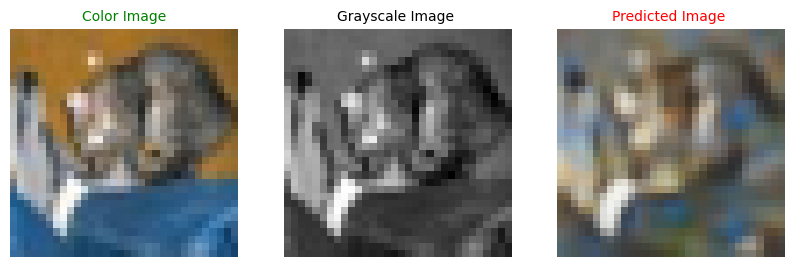

In [46]:

def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(10,10))

    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 10)
    plt.imshow(color)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 10)
    plt.imshow(grayscale , cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 10)
    plt.imshow(predicted)
    plt.axis('off')

    plt.show()


plot_images(x_test[0],x_test_gray[0],x_decoded[0])


In [28]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img


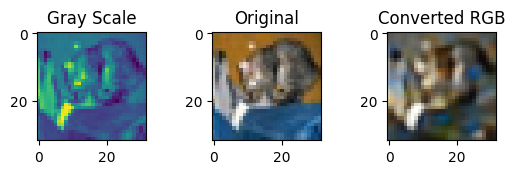

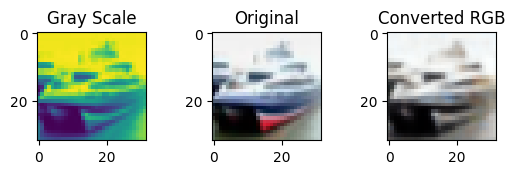

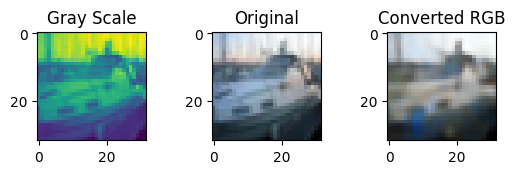

In [29]:
for i in range(0,3):
    fig = plt.figure()

    ax1 = fig.add_subplot(3,3,1)
    ax1.set_title("Gray Scale")
    ax1.imshow(array_to_img(x_test_gray[i]))

    ax2 = fig.add_subplot(3,3,2)
    ax2.set_title("Original")
    ax2.imshow(array_to_img(x_test[i]))

    ax3 = fig.add_subplot(3,3,3)
    ax3.set_title("Converted RGB")
    ax3.imshow(array_to_img(x_decoded[i]))

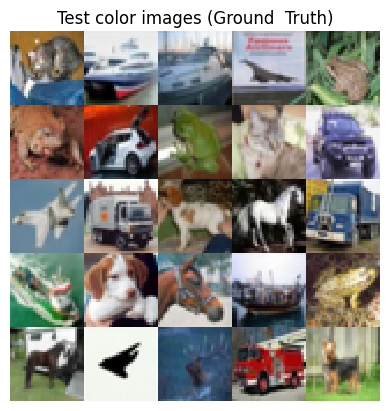

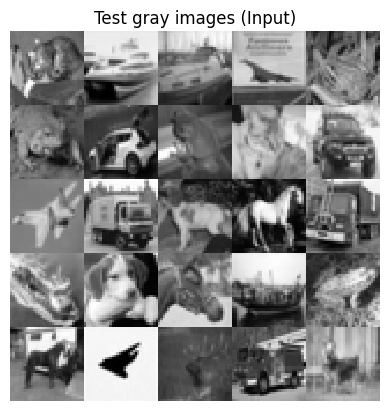

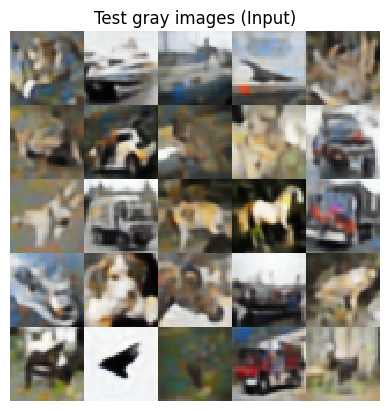

In [31]:
# display the 1st 100 input images (color and gray)
imgs = x_test[:25]
imgs = imgs.reshape((5, 5, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.show()

# display grayscale version of test images
imgs = x_test_gray[:25]
imgs = imgs.reshape((5, 5, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()

# display grayscale version of test images
imgs = x_decoded[:25]
imgs = imgs.reshape((5, 5, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')

plt.show()

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [61]:
img = cv2.imread('/content/drive/MyDrive/AI_Deep/horse.jpg' , cv2.IMREAD_GRAYSCALE)

img_resized = cv2.resize(img, (32, 32))

img_resized.shape

img_flatten = img_resized.reshape(1, 32, 32, 1)

# img_flatten = rgb2gray(img_flatten)
img_normalized = img_flatten.astype('float32')/255


In [64]:
predicted = autoencoder.predict(img_normalized)


1/1 [==============================] - 0s 46ms/step


In [67]:
predicted.shape

(1, 32, 32, 3)

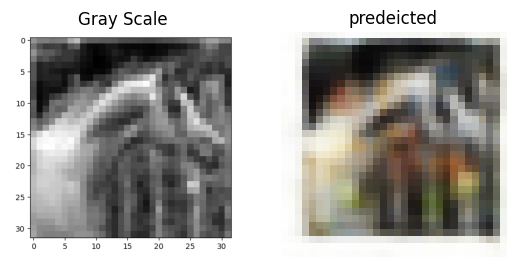

In [87]:
fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
ax1.set_title("Gray Scale")
ax1.axis('off')
ax1.imshow(img , cmap='gray')

ax2 = fig.add_subplot(1,2,2)
ax2.set_title("predeicted")
ax2.axis('off')
img_ = predicted.reshape((img_rows, img_cols, channels))
ax2.imshow(img_)

